In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from fine_tuning.pretrained_models.bisonai.models import OmniglotModelBisonai
from fine_tuning.data_factory import parse_train_data, parse_predict_data

In [2]:
### Parameters

num_classes = 3
learning_rate = 0.01
epochs = 100
checkpoint_path = "fine_tuning/pretrained_models/bisonai/1shot_3way_bisonai_ckpt_o15t/model.ckpt-99999"

## Data for fine-tuning & prediction

In [3]:
sess = tf.Session()

mnist_train = tfds.load(name="mnist", split=tfds.Split.TRAIN)
mnist_train = mnist_train.shuffle(1024)
mnist_example = mnist_train.take(1000)
mnist_example_iter = mnist_example.make_initializable_iterator()
sess.run(mnist_example_iter.initializer)

X_train = []
y_train = []

while len(y_train) != num_classes:
    data = mnist_example_iter.get_next()
    image = data['image']
    label = data['label']
    x, y = sess.run([image,label])
    if y not in set(y_train):
        X_train.append(x)    
        y_train.append(y)
    if len(y_train) == num_classes: 
        break
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

min = -1
max = 1
scale = (max - min) / (X_train.max() - X_train.min())
X_train = scale * X_train + min - X_train.min() * scale

(3, 28, 28, 1)
(3,)


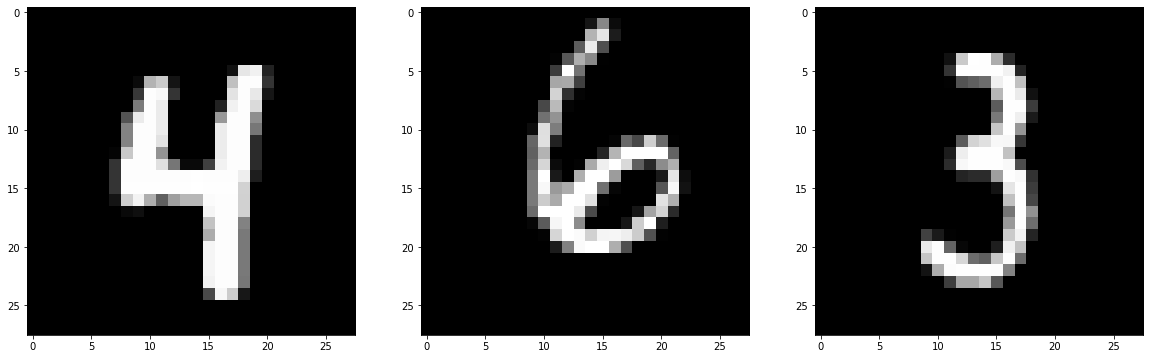

In [4]:
### Showing Images of the 3 classes after reshape 28x28x1

plt.figure(figsize=(20,20))
plt.subplot(131)
imgplot = plt.imshow(X_train[0,:,:,0], cmap="gist_gray")
plt.subplot(132)
imgplot = plt.imshow(X_train[1,:,:,0], cmap="gist_gray")
plt.subplot(133)
imgplot = plt.imshow(X_train[2,:,:,0], cmap="gist_gray")

In [5]:
mnist_test = tfds.load(name="mnist", split=tfds.Split.TEST)
mnist_test = mnist_test.shuffle(1024)
mnist_example = mnist_test.take(1000)
mnist_example_iter = mnist_example.make_initializable_iterator()
sess.run(mnist_example_iter.initializer)

while True:
    data = mnist_example_iter.get_next()
    image = data['image']
    label = data['label']
    x, y = sess.run([image,label])
    if y in set(y_train):
        X_predict = x
        break
    
X_predict = np.array(X_predict).reshape(1, 28, 28, 1)
print(X_predict.shape)

min = -1
max = 1
scale = (max - min) / (X_predict.max() - X_predict.min())
X_predict = scale * X_predict + min - X_predict.min() * scale

(1, 28, 28, 1)


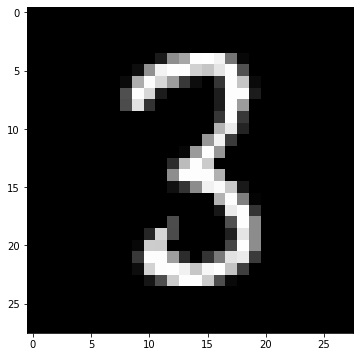

In [6]:
###### Showing the image with class to predict

plt.figure(figsize=(6,6))
imgplot = plt.imshow(X_predict[0,:,:,0], cmap="gist_gray")

## Preparing the model & prediction

In [7]:
model = OmniglotModelBisonai(num_classes=3)
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

In [8]:
y_train_label = np.array([0, 1, 2])

for e in range(epochs):
    sess.run(model.minimize_op, feed_dict={model.input_ph: X_train.reshape(X_train.shape[:3]), model.label_ph: y_train_label})
result = sess.run(model.predictions, feed_dict={model.input_ph: X_predict.reshape(X_predict.shape[:3])})

y_train[result[0]]

3